In [1]:
import numpy as np
import os
from math import ceil
import torch
import matplotlib

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Target():
    def __init__(self, cur_dat, energy=False):
        self.data = cur_dat
        self.energy = energy

    def get_logdensity(self, z, x=None, prior=None, args=None, prior_flow=None):
        if self.energy:
            z = z['points']
        if self.data == 't1':
            if len(z.shape) == 1:
                z = z.view(1, 2)
            z_norm = torch.norm(z, 2, 1)
            add1 = 0.5 * ((z_norm - 2) / 0.4) ** 2
            add2 = - torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2) + \
                               torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2) + 1e-9)
            if self.energy:
                return add1 + add2
            else:
                return -add1 - add2

        elif self.data == 't2':
            if len(z.shape) == 1:
                z = z.view(1, 2)
            w1 = torch.sin(2 * np.pi * z[:, 0] / 4)
            if self.energy:
                return 0.5 * ((z[:, 1] - w1) / 0.4) ** 2
            else:
                return -0.5 * ((z[:, 1] - w1) / 0.4) ** 2
        elif self.data == 't3':
            if len(z.shape) == 1:
                z = z.view(1, 2)
            w1 = torch.sin(2 * np.pi * z[:, 0] / 4)
            w2 = 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)
            in1 = torch.exp(-0.5 * ((z[:, 1] - w1) / 0.35) ** 2)
            in2 = torch.exp(-0.5 * ((z[:, 1] - w1 + w2) / 0.35) ** 2)
            if self.energy:
                return -torch.log(in1 + in2 + 1e-9)
            else:
                return torch.log(in1 + in2 + 1e-9)
        elif self.data == 't4':
            if len(z.shape) == 1:
                z = z.view(1, 2)
            w1 = torch.sin(2 * np.pi * z[:, 0] / 4)
            w3 = 3 * torch.sigmoid((z[:, 0] - 1) / 0.3)
            in1 = torch.exp(-0.5 * ((z[:, 1] - w1) / 0.4) ** 2)
            in2 = torch.exp(-0.5 * ((z[:, 1] - w1 + w3) / 0.35) ** 2)
            if self.energy:
                return -torch.log(in1 + in2 + 1e-9)
            else:
                return torch.log(in1 + in2 + 1e-9)
        else:
            raise RuntimeError

    def get_density(self, z, x=None):
        density = self.distr.log_prob(z).exp()
        return density

    def get_samples(self, n):
        raise NotImplementedError


In [3]:
paths = []
for filename in sorted(os.listdir('./rezende_data/'))[::-1]:
    if not filename.startswith('.'):
        paths.append(os.path.join('./', 'rezende_data', filename))

In [4]:
paths

['./rezende_data/rnvp_3.txt',
 './rezende_data/rnvp_2.txt',
 './rezende_data/rnvp_1.txt',
 './rezende_data/rnvp_0.txt',
 './rezende_data/nuts_3.txt',
 './rezende_data/nuts_2.txt',
 './rezende_data/nuts_1.txt',
 './rezende_data/nuts_0.txt',
 './rezende_data/methmc_3.txt',
 './rezende_data/methmc_2.txt',
 './rezende_data/methmc_1.txt',
 './rezende_data/methmc_0.txt',
 './rezende_data/hoffman_3.txt',
 './rezende_data/hoffman_2.txt',
 './rezende_data/hoffman_1.txt',
 './rezende_data/hoffman_0.txt']

In [5]:
samples_rnvp = []
samples_nuts = []
samples_methmc = []
samples_hoffman = []

for i, path in enumerate(paths):
    if i // 4 == 0:
        samples_rnvp.append(np.loadtxt(path))
    elif i // 4 == 1:
        samples_nuts.append(np.loadtxt(path))
    elif i // 4 == 2:
        samples_methmc.append(np.loadtxt(path))
    elif i // 4 == 3:
        samples_hoffman.append(np.loadtxt(path))
samples_rnvp = samples_rnvp[::-1]
samples_nuts = samples_nuts[::-1]
samples_methmc = samples_methmc[::-1]
samples_hoffman = samples_hoffman[::-1]

In [6]:
gamma = 0.75
limit = 4
step = 0.01
resolution = (10000, 10000)

In [7]:
npts = int(10000 ** 0.5)
xside = np.linspace(-limit, limit, npts)
yside = np.linspace(-limit, limit, npts)
xx, yy = np.meshgrid(xside, yside)


target_samples = []
for i, cur_dat in enumerate(['t1', 't2', 't3', 't4']):
    # First, let us plot target samples
    target = Target(cur_dat, energy=False)
    targ_log_dens = target.get_logdensity
    
    z = torch.tensor(np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]))
    u = -targ_log_dens(z)
    p = np.exp(-u).reshape(npts, npts)
    target_samples.append(p)

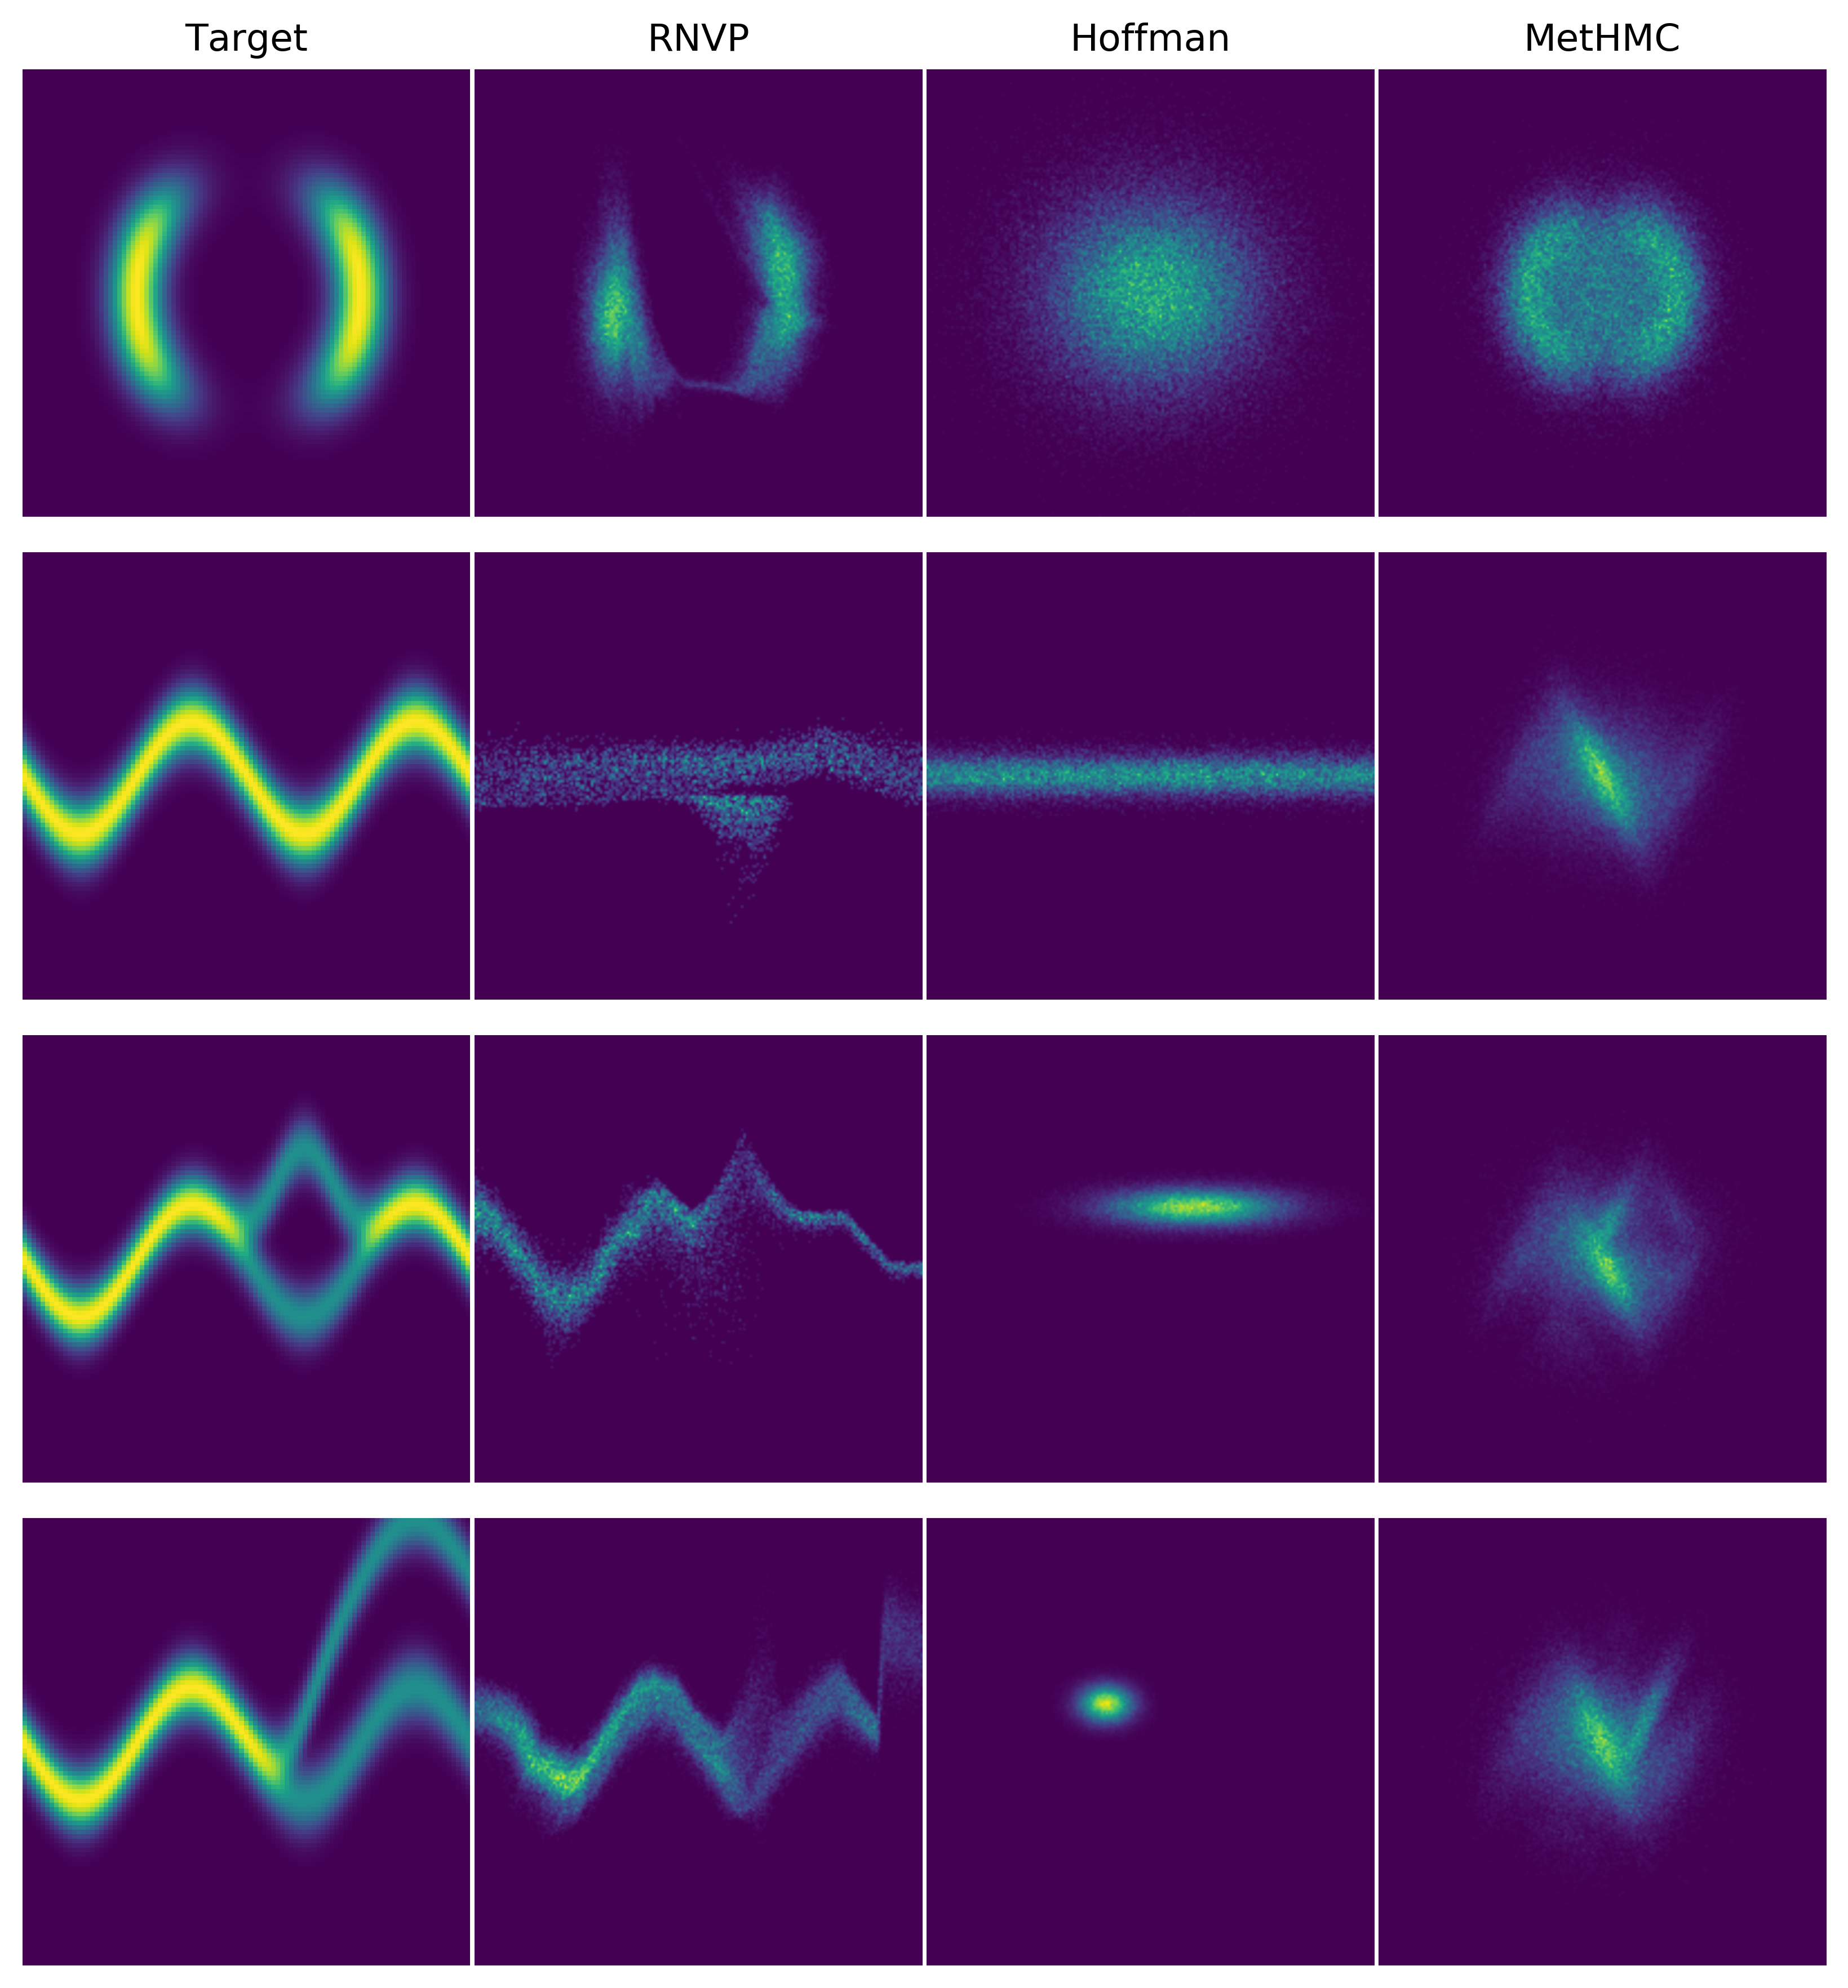

In [14]:
matplotlib.rcParams.update({'font.size': 10})
plt.rcParams['axes.facecolor'] = 'white'
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 9), dpi=400)
bins = 200
limit = 5

interpolation = 'gaussian'
cmap = None #'brg' # brg!, 


ax[0, 0].set_title('Target')
# ax[0, 1].set_title('NUTS')
ax[0, 1].set_title('RNVP')
ax[0, 2].set_title('Hoffman')
ax[0, 3].set_title('MetHMC')

for i in range(4):
#     h, _, _ = np.histogram2d(np.concatenate(stacked_mcmc_samples[i])[:, 0], np.concatenate(stacked_mcmc_samples[i])[:, 1],
#                              bins=bins, density=True, range=[[-limit, limit], [-limit, limit]])
#     ax[i, 0].imshow(h.T, interpolation='lanczos')
    ax[i, 0].pcolormesh(xx, yy, target_samples[i], cmap=cmap)
    ax[i, 0].invert_yaxis()
    ax[i, 0].get_xaxis().set_ticks([])
    ax[i, 0].get_yaxis().set_ticks([])
    ax[i, 0].set_aspect('equal')
    ax[i, 0].axis('off')
    
#     h, _, _ = np.histogram2d(samples_nuts[i][:, 0], samples_nuts[i][:, 1],
#                              bins=bins, density=True, range=[[-limit, limit], [-limit, limit]])
#     ax[i, 1].imshow(h.T, cmap=cmap, interpolation=interpolation)
#     ax[i, 1].set_aspect('equal')
#     ax[i, 1].axis('off')
    
    h, _, _ = np.histogram2d(samples_rnvp[i][:, 0], samples_rnvp[i][:, 1],
                             bins=bins, density=True, range=[[-limit, limit], [-limit, limit]])
    ax[i, 1].imshow(h.T, cmap=cmap, interpolation=interpolation)
    ax[i, 1].set_aspect('equal')
    ax[i, 1].axis('off')
    
    h, _, _ = np.histogram2d(samples_hoffman[i][:, 0], samples_hoffman[i][:, 1],
                             bins=bins, density=True, range=[[-limit, limit], [-limit, limit]])
    ax[i, 2].imshow(h.T, cmap=cmap, interpolation=interpolation)
    ax[i, 2].set_aspect('equal')
    ax[i, 2].axis('off')
    
    h, _, _ = np.histogram2d(samples_methmc[i][:, 0], samples_methmc[i][:, 1],
                             bins=bins, density=True, range=[[-limit, limit], [-limit, limit]])
    ax[i, 3].imshow(h.T, cmap=cmap, interpolation=interpolation)
    ax[i, 3].set_aspect('equal')
    ax[i, 3].axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0., right=1., bottom=0., top=0.95, wspace=0.01, hspace=0.01);
# plt.savefig('./rezende.png', format='png')

(-30, 30)

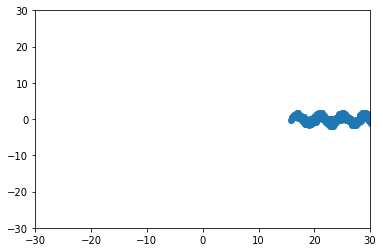

In [15]:
plt.scatter(samples_nuts[2][:, 0], samples_nuts[2][:, 1])
plt.xlim((-30, 30))
plt.ylim((-30, 30))